In [8]:
import numpy as np
from scipy.stats import bernoulli
from random import seed
from random import random
import pickle as pi

In [9]:
def initialize(k):
    beta_distn_reward = []
    for i in range(k):
        beta_distn_reward.append([0.0,0.0])

    return beta_distn_reward

def sample_reward(arm_pulled, mu):
    reward_received = bernoulli.rvs(mu[arm_pulled], size=1)[0]
    return reward_received

def update_distn(arm_pulled, beta_distn_reward, reward_received):
    beta_distn_reward[arm_pulled][0] += reward_received
    beta_distn_reward[arm_pulled][1] += (1-reward_received)
    return beta_distn_reward

def choose_arm(beta_distn_reward, k, mu):

    sampled_mean_reward = np.array([0]*k, dtype=np.float)

    for arm in range(k):
        sampled_mean_reward[arm] = np.random.beta(beta_distn_reward[arm][0]+1, beta_distn_reward[arm][1]+1)
    arm_pulled = np.argmax(sampled_mean_reward)
    reward_received = sample_reward(arm_pulled, mu)
    beta_distn_reward = update_distn(arm_pulled, beta_distn_reward, reward_received)

    return reward_received, arm_pulled, beta_distn_reward

def compute_best_arm(mu):
    return np.argmax(mu)

In [10]:
def fairness_without_budget_thompson_sampling(mu, T, k, alpha = None, r = None):
    reward_records = []
    arm_pulled_records = []
    arm_pulled_count = np.array([0]*k)

    beta_distn_reward = initialize(k)

    for t in range(T):
        unfair_arm = []
        unfair_val = []
        if(alpha is not None and r is not None):
            for i in range(k):
                if (r[i]*(t-1) - arm_pulled_count[i]) > alpha:
                    unfair_arm.append(i)
                    unfair_val.append(r[i]*(t-1) - arm_pulled_count[i])
        if unfair_arm:
            arm_pulled = unfair_arm[np.argmax(np.array(unfair_val))]
            reward_received = sample_reward(arm_pulled, mu)
            # print(cost_received)
            beta_distn_reward = update_distn(arm_pulled, beta_distn_reward, reward_received)
        else:
            reward_received, arm_pulled, beta_distn_reward = choose_arm(beta_distn_reward, k, mu)
        
        arm_pulled_count[arm_pulled] += 1
        reward_records.append(reward_received)
        arm_pulled_records.append(arm_pulled)


    return arm_pulled_count, reward_records, arm_pulled_records

In [37]:
def compute_regret(t,r,mu,reward_records):
  reward_received = np.sum(reward_records)
  reward_optimal_fair = np.sum(t*r*mu)+(1-np.sum(r))*t*np.max(np.array(mu))
  return reward_optimal_fair - reward_received

def compute_fair_violation(arm_pulled_count, T, r):
  return np.max(np.maximum(T*r - arm_pulled_count,0))




In [79]:
k = 10                          #Number of arms
mu = np.zeros(k)                #mean_rewards
# seed(1)
for i in range(k):
  mu[i] = random()

for i in range(k):
  mu[i] = (0.8-0.01*i)

T = count = 1000             #budget
# r = np.zeros(k)
r = np.array([0.05]*k)          #fairness_array for different arms
alphas = [10]                       #tolerance_parameter for fairness
nTimes = 1
###### FOR FAIRNESS########
regret_records = []
fair_violation_records = []
for alpha in alphas:
  regret_record = fair_record = 0
  for i in range(nTimes):
    arm_pulled_count, reward_records, arm_pulled_records = fairness_without_budget_thompson_sampling(mu, count, k, alpha, r)
    regret_record += compute_regret(count, r, mu, reward_records)
    fair_record += compute_fair_violation(arm_pulled_count, T, r)
  regret_records.append(regret_record/nTimes)
  fair_violation_records.append(fair_record/nTimes)

all_vars = (regret_records, fair_violation_records)
with open("thompson_only_fair_different_alphas.pickle", "wb") as w:
  pi.dump(all_vars, w)

w.close()

[20.5] [10.0]
2


In [60]:
k = 10                          #Number of arms
mu = np.zeros(k)                #mean_rewards
# seed(1)
for i in range(k):
  mu[i] = random()

for i in range(k):
  mu[i] = (0.8-0.01*i)

T = count = 200             #budget
# r = np.zeros(k)
r = np.array([0.05]*k)          #fairness_array for different arms
alphas = 0                      #tolerance_parameter for fairness
nTimes = 10
cumulative_regret = np.zeros(T)
for i in range(nTimes):
    cumulative_regret_each_time_step = []
    arm_pulled_count, reward_records, arm_pulled_records = fairness_without_budget_thompson_sampling(mu, count, k, alpha, r)
    for j in range(count):
        cumulative_regret_each_time_step.append(compute_regret(j+1, r, mu, reward_records[:j+1]))
    cumulative_regret += np.array(cumulative_regret_each_time_step)

cumulative_regret /= nTimes
print (cumulative_regret[-1])
all_vars = (cumulative_regret)
with open("thompson_only_fair_different_cumulative_regret_vs_time.pickle", "wb") as w:
  pi.dump(all_vars, w)

w.close()

3.4


In [81]:
k = 10                          #Number of arms
mu = np.zeros(k)                #mean_rewards
# seed(1)
for i in range(k):
  mu[i] = random()

for i in range(k):
  mu[i] = (0.8-0.01*i)

T = count = 200             #budget
# r = np.zeros(k)
r = np.array([0.05]*k)          #fairness_array for different arms
alphas = 0                      #tolerance_parameter for fairness
nTimes = 10
fairness_violation_cumulative = np.zeros(count)
for i in range(nTimes):
    fair_viol_each_time_step = []
    for t in range(count):
        arm_pulled_count, reward_records, arm_pulled_records = fairness_without_budget_thompson_sampling(mu, t+1, k, alpha, r)
        fairness_violation_cumulative[t] += compute_fair_violation(arm_pulled_count, t, r)
fairness_violation_cumulative /= nTimes

print(fairness_violation_cumulative)
all_vars = (fairness_violation_cumulative)
with open("thompson_only_fair_different_cumulative_fairness_vs_time.pickle", "wb") as w:
  pi.dump(all_vars, w)

w.close()

[0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
 0.6   0.65  0.7   0.75  0.72  0.85  0.9   0.95  0.8   0.95  1.    0.85
 1.2   1.05  1.2   1.05  1.    1.05  1.3   1.05  1.2   1.15  1.5   1.175
 1.02  1.35  1.6   1.45  1.4   1.05  1.2   1.15  1.5   1.55  1.7   1.85
 1.6   1.45  1.6   1.65  1.3   1.85  2.    1.95  2.    2.05  1.9   1.95
 1.7   2.05  1.7   2.05  2.3   2.05  2.2   2.35  2.3   2.35  2.4   2.45
 2.3   2.65  2.6   2.65  2.7   2.25  3.    2.555 2.4   2.65  3.1   2.55
 2.4   2.55  3.    3.15  2.6   2.95  3.2   2.75  3.2   2.85  3.1   3.175
 3.5   3.45  3.9   3.55  3.6   3.55  3.5   3.85  3.7   4.05  4.1   3.75
 3.5   3.85  3.55  3.85  3.6   3.95  4.1   3.95  4.2   4.55  4.1   4.05
 4.5   4.45  4.1   4.55  3.98  4.15  4.8   4.65  4.    4.85  5.    4.45
 4.3   5.05  4.7   4.75  5.2   4.75  3.61  4.95  5.7   5.65  4.7   5.55
 5.4   5.65  5.5   5.25  5.6   5.35  5.7   5.15  5.1   5.85  5.8   5.35
 5.    6.05  6.    5.65  5.4   5.55  5.5   6.25  6.1   6.05  6

51


673.5678929106435


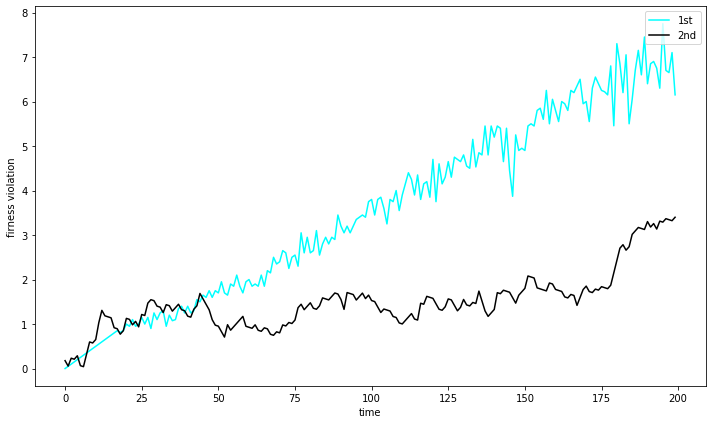

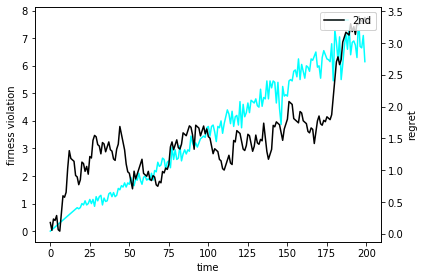

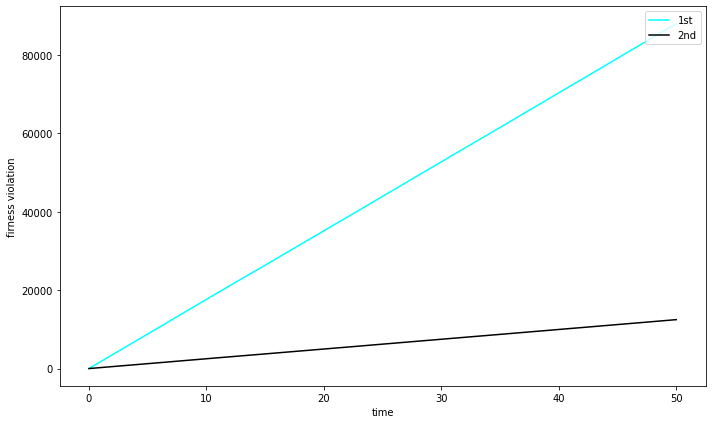